# Coronagraph

In [1]:
import morphine
import numpy
import pickle

import jax
import jax.numpy as np
from jax import jit, vmap, grad

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings("ignore")

from funcs import *

In [2]:
# We used jax version 0.1.75
jax.version.__version__

'0.1.75'

## Set constants

In [3]:
N = 75 # number of modes
PPSZ = 256
PSZ = PPSZ*3 # For every 'pixel', represent as 3x3 pixels so tht gradients can be calculated
SYM = 8
ISZ = 128
WAVELENGTH = 1.6e-6 # nm
Q = PSZ//2

## Pupil support

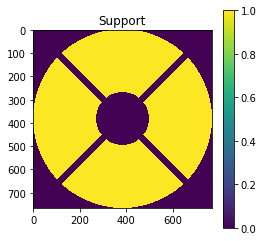

In [4]:
support = get_support(PSZ, secondary_ratio = 13/44, spider_width = 0.05)

plt.figure(figsize = (4, 4))
plt.imshow(support, interpolation = 'none'); plt.title('Support'); plt.colorbar()
plt.show()

## Define constraints

The purpose of these masks is to isolate regions in the PSF that we either want to darken or brighten. We use these masks in the objective function.

**Dark annulus**
Reduce light in the ring.

**Central peak**
Maintain light at the very center of the PSF to maintain a high contrast ratio.

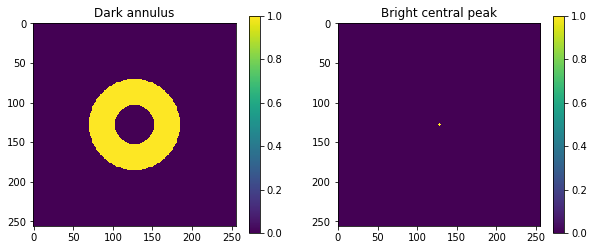

In [5]:
# Dark annulus
r = radius_meshgrid(ISZ)
minr = 24.6; maxr = 57.4
mask = (r<(maxr*2/(ISZ*2)))*(r>(minr*2/(ISZ*2)))

# Central peak
light_mask = (r < (2 * 2/(ISZ * 2)))

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1); plt.imshow(mask, interpolation = 'none');
plt.colorbar(); plt.title('Dark annulus')
plt.subplot(1, 2, 2); plt.imshow(light_mask, interpolation = 'none'); plt.colorbar();
plt.title('Bright central peak')
plt.show()

In [6]:
wf = np.zeros((PSZ, PSZ))

psf, _ = get_psf(wf, support, psz = PSZ)
mp = np.max(psf)

## Load basis

For this demonstration we use a basis with just 75 modes.

In [7]:
basis = np.load('./coronagraph_basis.npy').astype('float32')

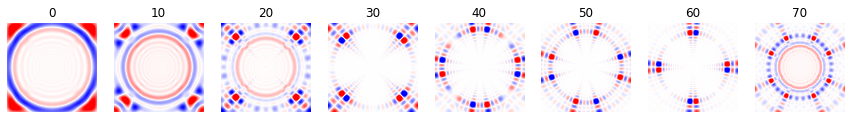

In [8]:
v = 30
plt.figure(figsize = (15, 5.5))
samples = [0, 10, 20, 30, 40, 50, 60, 70]
for i in range(len(samples)):
    plt.subplot(1, 8, i + 1);
    plt.imshow(basis[:, samples[i]].reshape(PSZ, PSZ), vmin = -v, vmax = v, cmap = 'bwr'); plt.axis('off'); plt.title(samples[i])

# **Mode basis**

## Initialize

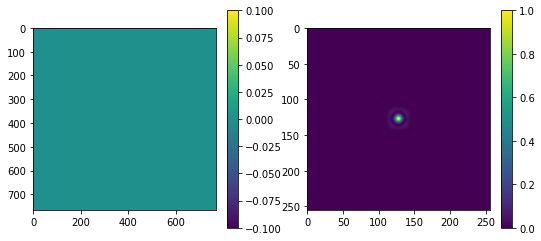

In [9]:
numpy.random.seed(0)
coeffs = 1e-3*numpy.random.rand(N)
    
wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)
wf = np.zeros((PSZ, PSZ))

psf, _ = get_psf(wf, support, psz = PSZ)

plt.figure(figsize = (9, 4))
plt.subplot(1, 2, 1); plt.imshow(wf); plt.colorbar()
plt.subplot(1, 2, 2); plt.imshow(psf/mp); plt.colorbar()
plt.show()

## Define objective function

In [10]:
def objective_function(coeffs, basis, support, mask, light_mask, PSZ, c1, c2):
    wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)

    psf, _ = get_psf(wf, support, psz = PSZ)
    
    dark_peak = np.max(mask*psf)
    max_peak = np.max(light_mask * psf)
    
    return c1 * dark_peak + c2 * max_peak

## Run gradient descent

In [11]:
def objective_function(coeffs, basis, support, mask, light_mask, PSZ, c1, c2):
    wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)

    psf, _ = get_psf(wf, support, psz = PSZ)
    
    dark_peak = np.max(mask*psf)
    max_peak = np.max(light_mask * psf)
    
    return c1 * dark_peak + c2 * max_peak

In [12]:
results = []

In [13]:
def gradient_descent(coeffs, epochs, learning_rate, results, c1, c2, save_rate = 100):
    grad_obj = (grad(objective_function))
    for i in range(epochs):
        coeffs -= lr*grad_obj(coeffs, basis, support, mask, light_mask, PSZ, c1, c2)

        wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)
        psf, _ = get_psf(wf, support, psz = PSZ)
        
        if i % save_rate == 0:
            results.append(coeffs)
            
    results.append(coeffs)

In [14]:
lr = 1e-4
epochs = 200; gradient_descent(coeffs, epochs, lr, results, c1 = 2e3, c2 = -1e2)

lr = 1e-5
c1 = 1e4
for i in range(1, 7):
    epochs = 500; gradient_descent(results[-1], epochs, lr, results, c1 = c1, c2 = -1e2)
    c1 *= 2

lr = 1e-6
c1 = 1e5
for i in range(1, 7):
    epochs = 500; gradient_descent(results[-1], epochs, lr, results, c1 = c1, c2 = -1e2)
    c1 *= 2

In [15]:
results = np.array(results)
with open('corona_mode_coeffs.npy', 'wb') as f:
    np.save(f, results)

## Results

In [11]:
results = np.load('corona_mode_coeffs.npy')

In [12]:
final_coeffs = results[-1]

final_wf = np.dot(basis, final_coeffs).reshape(PSZ, PSZ)
final_psf, _ = get_psf(final_wf, support, psz = PSZ)
norm_psf = final_psf/mp

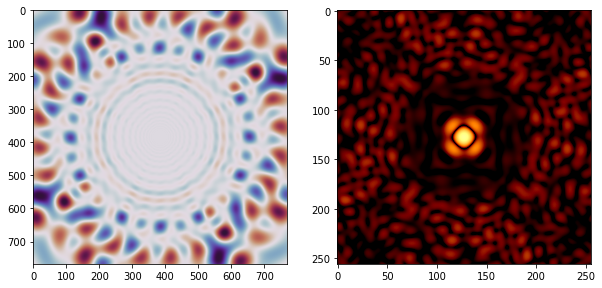

In [13]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1); plt.imshow(final_wf, cmap = 'twilight_shifted')
plt.subplot(1, 2, 2); plt.imshow(norm_psf, cmap = 'afmhot', norm = LogNorm(vmin = 1e-4, vmax = 1))
plt.show()

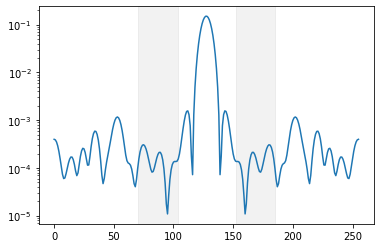

In [14]:
c = norm_psf.shape[0]//2
cross_secx = norm_psf[c-1:c+1, :].mean(axis = 0)
cross_secy = norm_psf[:, c-1:c+1].mean(axis = 1)
cross_sec = (cross_secx + cross_secy)/2

fig, ax = plt.subplots()
plt.plot(cross_sec); plt.yscale('log')
ax.axvspan(c-minr, c-maxr, alpha=0.1, color='grey'); 
ax.axvspan(c+minr, c+maxr, alpha=0.1, color='grey')
plt.show()

# **Pixel basis**

## Initialize

In [9]:
results = np.load('corona_mode_coeffs.npy')
coeffs = results[-1]

In [10]:
wf = np.dot(basis, coeffs).reshape(PSZ, PSZ)

qwfA = wf[:Q, :Q] # quater wavefront

qwfB, qwfC, qwfD = np.rot90(qwfA, k = 3), np.rot90(qwfA, k = 2), np.rot90(qwfA, k = 1)
top, bottom = np.hstack((qwfA, qwfB)), np.hstack((qwfD, qwfC))
wf = np.vstack((top, bottom))

coeffs = qwfA.reshape(-1)

## Define new objective function

Since we have 4-fold symmetry, we only need to optimize pixels in one quadrant and then tile these pixels to fill the pupil.

In [12]:
def objective_function(coeffs, basis, support, mask, light_mask, Q, c1, c2):
    
    qwfA = coeffs.reshape(Q, Q)
    
    qwfB, qwfC, qwfD = np.rot90(qwfA, k = 3), np.rot90(qwfA, k = 2), np.rot90(qwfA, k = 1)
    top, bottom = np.hstack((qwfA, qwfB)), np.hstack((qwfD, qwfC))
    wf = np.vstack((top, bottom))

    psf, _ = get_psf(wf, support, psz = PSZ)
    
    dark_peak = np.max(mask*psf)
    max_peak = np.max(light_mask * psf)
    
    return c1 * dark_peak + c2 * max_peak

In [13]:
results = []

In [14]:
def gradient_descent(coeffs, epochs, learning_rate, results, c1, c2, save_rate = 100):
    grad_obj = (grad(objective_function))
    for i in range(epochs):
        coeffs -= lr*grad_obj(coeffs, basis, support, mask, light_mask, Q, c1, c2)

        qwfA = coeffs.reshape(Q, Q)
        qwfB, qwfC, qwfD = np.rot90(qwfA, k = 3), np.rot90(qwfA, k = 2), np.rot90(qwfA, k = 1)
        top, bottom = np.hstack((qwfA, qwfB)), np.hstack((qwfD, qwfC))
        
        wf = np.vstack((top, bottom))
        psf, _ = get_psf(wf, support, psz = PSZ)
        
        if i % save_rate == 0:
            results.append(coeffs)
            
    results.append(coeffs)

In [15]:
lr = 1
epochs = 1000; gradient_descent(coeffs, epochs, lr, results, c1 = 2e5, c2 = -1e2)
epochs = 1000; gradient_descent(results[-1], epochs, lr, results, c1 = 5e5, c2 = -1e2)

lr = 1;   epochs = 1000; gradient_descent(results[-1], epochs, lr, results, c1 = 1e6, c2 = -1e2)
lr = 0.1; epochs = 1000; gradient_descent(results[-1], epochs, lr, results, c1 = 1e6, c2 = -1e2)

lr = 1;   epochs = 1000; gradient_descent(results[-1], epochs, lr, results, c1 = 2e6, c2 = -1e2)
lr = 0.1; epochs = 1000; gradient_descent(results[-1], epochs, lr, results, c1 = 2e6, c2 = -1e2)

In [16]:
results = np.array(results)
with open('corona_px_coeffs.npy', 'wb') as f:
    np.save(f, results)

## Results

In [17]:
results = np.load('corona_px_coeffs.npy')

In [18]:
final_coeffs = results[-1]

qwfA = final_coeffs.reshape(Q, Q)

qwfB, qwfC, qwfD = np.rot90(qwfA, k = 3), np.rot90(qwfA, k = 2), np.rot90(qwfA, k = 1)
top, bottom = np.hstack((qwfA, qwfB)), np.hstack((qwfD, qwfC))

final_wf = np.vstack((top, bottom))
final_psf, _ = get_psf(final_wf, support, psz = PSZ)
norm_psf = final_psf/mp

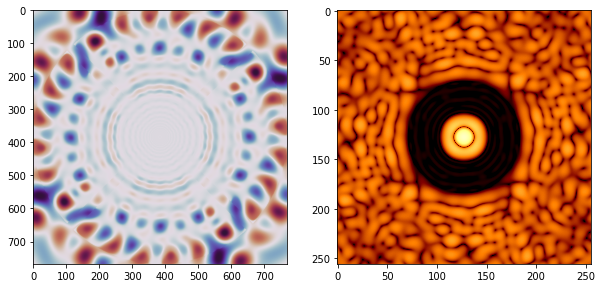

In [21]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1); plt.imshow(final_wf, cmap = 'twilight_shifted')
plt.subplot(1, 2, 2); plt.imshow(norm_psf, cmap = 'afmhot', norm = LogNorm(vmin = 1e-6, vmax = 1))
plt.show()

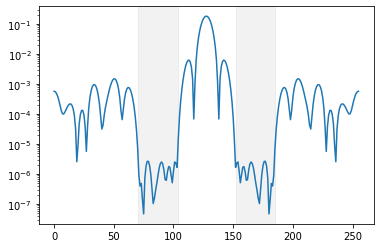

In [22]:
c = norm_psf.shape[0]//2
cross_secx = norm_psf[c-1:c+1, :].mean(axis = 0)
cross_secy = norm_psf[:, c-1:c+1].mean(axis = 1)
cross_sec = (cross_secx + cross_secy)/2

fig, ax = plt.subplots()
plt.plot(cross_sec); plt.yscale('log')
ax.axvspan(c-minr, c-maxr, alpha=0.1, color='grey'); 
ax.axvspan(c+minr, c+maxr, alpha=0.1, color='grey')
plt.show()